# Fix Environment

In [1]:
!nvidia-smi

Wed Feb  5 12:10:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 PCIe               Off |   00000000:4A:00.0 Off |                    0 |
| N/A   27C    P0             49W /  350W |       4MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
!rm -rf ./sample_data

# Preprocess Data

In [3]:
import os
import tarfile
import urllib.request

In [4]:
IMAGE_DIR = "./images"
DATASET_DIR = "./dataset"

In [5]:
# URLs for the zip files
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
]


os.makedirs(DATASET_DIR, exist_ok=True)

for index, link in enumerate(links):
    tar = "images_%02d.tar.gz" % (index + 1)
    tar_path = os.path.join(DATASET_DIR, tar)
    urllib.request.urlretrieve(link, tar_path)
    print(f"Downloaded {tar}")

    with tarfile.open(tar_path, "r") as tar:
        for member in tar.getmembers():
            if member.isfile() and member.name.lower().endswith(".png"):
                member.name = os.path.basename(member.name)  # remove the path
                tar.extract(member, path=IMAGE_DIR)
    print(f"Extracted {tar}")

    os.remove(tar_path)

print("Download and extraction complete")

Downloaded images_01.tar.gz


/usr/lib64/python3.9/tarfile.py:2268: RuntimeWarning: The default behavior of tarfile extraction has been changed to disallow common exploits (including CVE-2007-4559). By default, absolute/parent paths are disallowed and some mode bits are cleared. See https://access.redhat.com/articles/7004769 for more details.
  warnings.warn(


Extracted <tarfile.TarFile object at 0x7f07c1cb5880>
Downloaded images_02.tar.gz
Extracted <tarfile.TarFile object at 0x7f07c1130a90>
Download and extraction complete


## Create Binary Matrix CSV that maps all images with its labels

In [7]:
import pandas as pd

ORIGINAL_CSV = "./dataset/Data_Entry_2017.csv"
BINARY_MATRIX_CSV = "all_labels.csv"

df = pd.read_csv(ORIGINAL_CSV, usecols=["Image Index", "Finding Labels"])
df["Finding Labels"] = df["Finding Labels"].fillna("")

# Get all possible labels
unique_labels_set = set()
labels_series = df["Finding Labels"].str.split("|")
for labels in labels_series:
    for label in labels:
        if label and label != "No Finding":
            unique_labels_set.add(label)
unique_labels = sorted(unique_labels_set)

# Fill in binary matrix CSV
for label in unique_labels:
    df[label] = df["Finding Labels"].apply(lambda x: 1 if label in x.split("|") else 0)
binary_df = df[["Image Index"] + unique_labels]

binary_df.to_csv(BINARY_MATRIX_CSV, index=False)

In [8]:
binary_df

Image Index  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0       00000001_000.png            0             1              0      0   
1       00000001_001.png            0             1              0      0   
2       00000001_002.png            0             1              0      0   
3       00000002_000.png            0             0              0      0   
4       00000003_000.png            0             0              0      0   
...                  ...          ...           ...            ...    ...   
112115  00030801_001.png            0             0              0      0   
112116  00030802_000.png            0             0              0      0   
112117  00030803_000.png            0             0              0      0   
112118  00030804_000.png            0             0              0      0   
112119  00030805_000.png            0             0              0      0   

        Effusion  Emphysema  Fibrosis  Hernia  Infiltration  Mass  Nodule  \
0              0          0         0       0             0     0       0   
1              0          1         0       0             0     0       0   
2              1          0         0       0             0     0       0   
3              0          0         0       0             0     0       0   
4              0          0         0       1             0     0       0   
...          ...        ...       ...     ...           ...   ...     ...   
112115         0          0         0       0             0     1       0   
112116         0          0         0       0             0     0       0   
112117         0          0         0       0             0     0       0   
112118         0          0         0       0             0     0       0   
112119         0          0         0       0             0     0       0   

        Pleural_Thickening  Pneumonia  Pneumothorax  
0                        0          0             0  
1                        0          0             0  
2                        0          0             0  
3                        0          0             0  
4                        0          0             0  
...                    ...        ...           ...  
112115                   0          1             0  
112116                   0          0             0  
112117                   0          0             0  
112118                   0          0             0  
112119                   0          0             0  

[112120 rows x 15 columns]

In [8]:
directory = "images/"
if os.listdir(directory):
    print("Directory is not empty")
else:
    print("Directory is empty")

Directory is not empty


## Split training and validation data


In [9]:
TRAIN_CSV = "train_labels.csv"
VAL_CSV = "val_labels.csv"

df = pd.read_csv(BINARY_MATRIX_CSV)

RANDOM_SEED = 42  # Chosen arbitrarily for reproducibility
train_df = df.sample(frac=0.8, random_state=RANDOM_SEED)
val_df = df.drop(train_df.index)

train_df.to_csv(TRAIN_CSV, index=False)
val_df.to_csv(VAL_CSV, index=False)

## Move the extracted images files in ./images into their respective folder


In [10]:
# Move the extracted images files in ./images into their respective folder
import shutil

TRAIN_DIR = "./train"
VAL_DIR = "./val"

os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)

for image in train_df["Image Index"]:
    src = os.path.join(IMAGE_DIR, image)
    dst = os.path.join(TRAIN_DIR, image)
    if os.path.exists(src):
        shutil.move(src, dst)

for image in val_df["Image Index"]:
    src = os.path.join(IMAGE_DIR, image)
    dst = os.path.join(VAL_DIR, image)
    if os.path.exists(src):
        shutil.move(src, dst)

In [157]:
directory = "images/"
if os.listdir(directory):
    print("Directory is not empty")
else:
    print("Directory is empty")

Directory is empty


# Train

In [11]:
import torch
import torch.nn as nn
from torchvision import transforms, models, datasets

In [25]:
batch_size = 64
learning_rate = 3e-4
device = torch.device("cuda") # if torch.cuda.is_available() else "cpu")

## Define Transform and Albumentations

In [26]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2  # Needed for interpolation constants

def get_train_transform():
    return A.Compose([
        A.Resize(height=256, width=256),  # Resize before cropping
        A.RandomCrop(height=224, width=224),  # Random crop for variation
        A.HorizontalFlip(p=0.5),
        A.Affine(scale=(0.98, 1.02), translate_percent=(0.02, 0.02), rotate=(-5, 5), p=0.3),
        A.Perspective(scale=0.1, p=0.5),  # Added from augmented repo
        A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
        A.MotionBlur(blur_limit=(3, 7), p=0.1),
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
        A.ElasticTransform(alpha=1, sigma=50, p=0.1),
        A.CoarseDropout(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

def get_val_transform():
    return A.Compose([
        A.Resize(height=256, width=256, interpolation=cv2.INTER_LINEAR),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

In [27]:
import os
import torch
import pandas as pd
import numpy as np
import cv2
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

class ChestXrayDataset(Dataset):
    def __init__(self, images_dir, csv_file, transform=None):
        self.images_dir = images_dir
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform

        # Get image names and labels
        self.image_names = self.annotations.iloc[:, 0].values
        self.labels = self.annotations.iloc[:, 1:].values.astype(float)

        # Filter out missing images
        existing_images = []
        existing_labels = []

        for img_name, label in zip(self.image_names, self.labels):
            img_path = os.path.join(self.images_dir, img_name)
            if os.path.exists(img_path):  # Check if image exists
                existing_images.append(img_name)
                existing_labels.append(label)
            else:
                print(f"Warning: {img_name} not found. Skipping...")

        self.image_names = existing_images
        self.labels = existing_labels
        self.num_classes = len(self.labels[0]) if self.labels else 0
        self.class_labels = list(self.annotations.columns)[1:]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.image_names[idx])
        
        # Load image using PIL, then convert to NumPy for Albumentations
        image = Image.open(img_name).convert("RGB")
        image = np.array(image)  # Convert PIL image to NumPy array

        labels = torch.FloatTensor(self.labels[idx])

        # Apply Albumentations transform
        if self.transform:
            augmented = self.transform(image=image)  # Albumentations expects a dictionary
            image = augmented["image"]  # Extract transformed image

        return image, labels

In [28]:
# Create datasets with correct transforms
train_dataset = ChestXrayDataset(
    images_dir=TRAIN_DIR,
    csv_file=TRAIN_CSV,
    transform=get_train_transform()  
)
val_dataset = ChestXrayDataset(
    images_dir=VAL_DIR,
    csv_file=VAL_CSV,
    transform=get_val_transform()  
)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)


In [29]:
import torch
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import time
import sys
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

In [30]:
import torch.nn as nn
import torchvision.models as models

class OptimizedChestXRayResNet(nn.Module):
    def __init__(self, num_classes=14):
        super(OptimizedChestXRayResNet, self).__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)  # FIX pretrained warning
        
        # Unfreeze more layers (layer2, layer3, layer4)
        for param in self.model.parameters():
            param.requires_grad = False  # Freeze everything initially

        for param in self.model.layer2.parameters():
            param.requires_grad = True  # Unfreezing layer2
        for param in self.model.layer3.parameters():
            param.requires_grad = True  # Unfreezing layer3
        for param in self.model.layer4.parameters():
            param.requires_grad = True  # Unfreezing layer4

        # Refine classifier head
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.BatchNorm1d(1024),  
            nn.ReLU(),
            nn.Dropout(0.5),  
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OptimizedChestXRayResNet(num_classes=14).to(device)


In [31]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()


In [40]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import OneCycleLR

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

optimizer = optim.AdamW([
    {"params": model.model.layer2.parameters(), "lr": 2e-5, "weight_decay": 4e-5},
    {"params": model.model.layer3.parameters(), "lr": 3.5e-5, "weight_decay": 4e-5},
    {"params": model.model.layer4.parameters(), "lr": 8.5e-5, "weight_decay": 4e-5},
    {"params": model.model.fc.parameters(), "lr": 2.0e-4, "weight_decay": 4e-5}
])

max_lr = 5e-4  # Peak LR remains the same

scheduler = OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=len(train_loader),
    epochs=18,
    pct_start=0.4,  # ⬆ More time in warm-up
    anneal_strategy='cos',
    div_factor=2,  # ⬆ Reduce LR less aggressively
    final_div_factor=10  # ⬆ Don't decay LR too much
)




criterion = FocalLoss(gamma=1.5, alpha=0.25)
 # Increase from 3.0
 





✅ Filtered dataset size: (11954, 15)
✅ Adjusted dataset size after manual balancing: (19078, 15)
✅ **Manually Balanced Dataset Applied Successfully!** 🎯


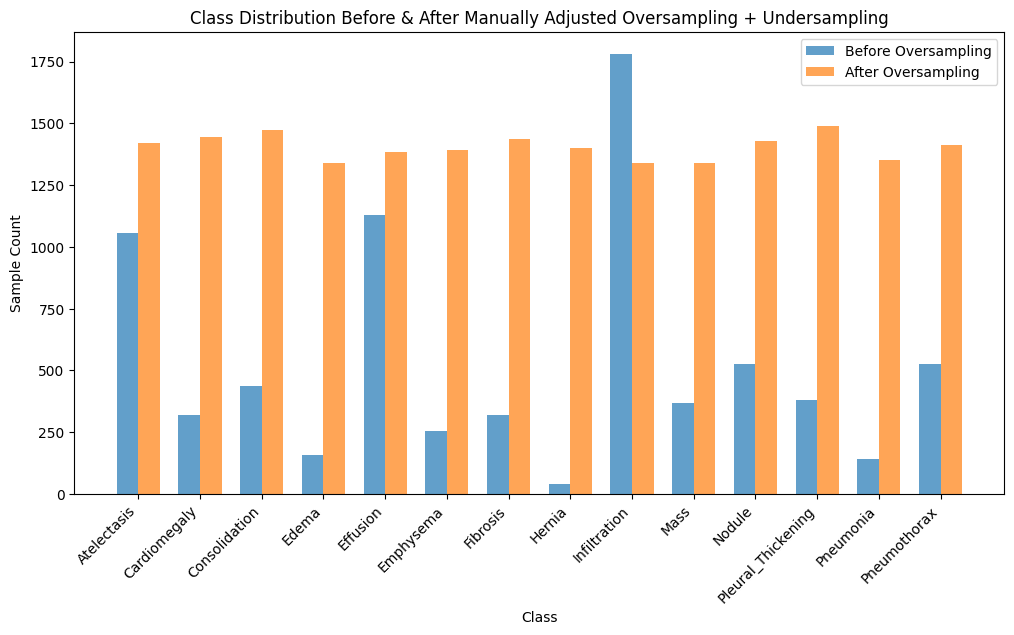

In [41]:
import numpy as np 
import pandas as pd
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
import os
import matplotlib.pyplot as plt

# Step 1: Filter existing training images
existing_train_images = set(os.listdir(TRAIN_DIR))
filtered_train_df = train_df[train_df["Image Index"].isin(existing_train_images)].reset_index(drop=True)

print("Filtered dataset size:", filtered_train_df.shape)

# Step 2: Identify class counts
class_counts = filtered_train_df.iloc[:, 1:].sum().to_dict()
max_count = max(class_counts.values())

# Step 3: **Manually Balanced Oversampling + Undersampling**
oversampled_train_df = filtered_train_df.copy()

for class_label, count in class_counts.items():
    # Set manual target counts based on the chart
    if class_label == "Atelectasis":
        target_count = int(0.17 * max_count)
    elif class_label == "Cardiomegaly":
        target_count = int(0.99 * max_count)
    elif class_label == "Consolidation":
        target_count = int(0.98 * max_count)
    elif class_label == "Edema":
        target_count = int(1.37 * max_count)
    elif class_label == "Effusion":
        target_count = int(0.32 * max_count)  
    elif class_label == "Emphysema":
        target_count = int(0.8 * max_count)
    elif class_label == "Fibrosis":
        target_count = int(0.84 * max_count)
    elif class_label == "Hernia":
        target_count = int(0.88 * max_count)  
    elif class_label == "Infiltration":
        target_count = int(0.3 * max_count)  
    elif class_label == "Mass":
        target_count = int(0.58 * max_count)
    elif class_label == "Nodule":
        target_count = int(0.55 * max_count)
    elif class_label == "Pleural_Thickening":
        target_count = int(0.6 * max_count)
    elif class_label == "Pneumonia":
        target_count = int(0.72 * max_count)
    elif class_label == "Pneumothorax":
        target_count = int(0.60 * max_count)
    else:
        target_count = int(0.85 * max_count)  

    num_new_samples = target_count - count
    class_samples = filtered_train_df[filtered_train_df[class_label] == 1]

    if num_new_samples > 0:  # **Oversample if below target**
        oversampled_samples = class_samples.sample(n=num_new_samples, replace=True, random_state=42)
        oversampled_train_df = pd.concat([oversampled_train_df, oversampled_samples])
    elif num_new_samples < 0:  # **Undersample if above target**
        undersampled_samples = class_samples.sample(n=target_count, random_state=42)
        oversampled_train_df = oversampled_train_df[~oversampled_train_df["Image Index"].isin(class_samples["Image Index"])]
        oversampled_train_df = pd.concat([oversampled_train_df, undersampled_samples])

print("Adjusted dataset size after manual balancing:", oversampled_train_df.shape)

# Step 4: Compute class weights for Weighted Sampling
class_counts_after = oversampled_train_df.iloc[:, 1:].sum().to_numpy()
adjusted_class_weights = 1.0 / (class_counts_after + 1e-6)  # Avoid division by zero

# Normalize weights for better balance
adjusted_class_weights = adjusted_class_weights / adjusted_class_weights.sum()

# Step 5: Assign sample weights per image
train_indices = train_dataset.indices if hasattr(train_dataset, "indices") else range(len(train_dataset))
sample_weights = np.zeros(len(oversampled_train_df))

for idx, row in oversampled_train_df.iloc[:, 1:].iterrows():
    disease_weights = adjusted_class_weights[row.astype(bool)]
    sample_weights[idx] = disease_weights.mean() if len(disease_weights) > 0 else adjusted_class_weights.mean()

# Normalize sample weights
sample_weights = sample_weights / sample_weights.sum()

# Convert to PyTorch tensor & Apply WeightedRandomSampler
sample_weights = torch.tensor(sample_weights, dtype=torch.float32)
sampler = WeightedRandomSampler(weights=sample_weights.numpy(), num_samples=len(sample_weights), replacement=True)

# Step 6: Apply sampler to DataLoader
train_loader = DataLoader(train_dataset, batch_size=96, sampler=sampler, num_workers=4, pin_memory=True)

print("**Manually Balanced Dataset Applied Successfully!** ")

# Step 7: **Visualize Class Distribution Before & After Adjustments**
def plot_class_distribution(before_counts, after_counts, class_labels):
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(class_labels))
    width = 0.35

    ax.bar(x - width/2, before_counts, width, label="Before Oversampling", alpha=0.7)
    ax.bar(x + width/2, after_counts, width, label="After Oversampling", alpha=0.7)

    ax.set_xlabel("Class")
    ax.set_ylabel("Sample Count")
    ax.set_title("Class Distribution Before & After Manually Adjusted Oversampling + Undersampling")
    ax.set_xticks(x)
    ax.set_xticklabels(class_labels, rotation=45, ha="right")
    ax.legend()

    plt.show()

# Compute class distributions
before_counts = [filtered_train_df[class_label].sum() for class_label in class_counts.keys()]
after_counts = [oversampled_train_df[class_label].sum() for class_label in class_counts.keys()]

# Plot the class distribution changes
plot_class_distribution(before_counts, after_counts, list(class_counts.keys()))


In [42]:
from tqdm import tqdm
import time
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, precision_recall_curve

# Training setup
patience = 8
counter = 0
best_val_loss = float("inf")
num_epochs = 18  # Adjust as needed

start_time = time.time()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0

    # Live progress bar for training
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=True)

    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # Update tqdm progress bar with current loss
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    all_preds = []
    all_labels = []

    # Live progress bar for validation
    with torch.no_grad():
        val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=True)

        for images, labels in val_progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)

            # Convert logits to probabilities using sigmoid
            preds = torch.sigmoid(outputs).cpu().numpy()
            labels = labels.cpu().numpy()

            all_preds.append(preds)
            all_labels.append(labels)

            # Update validation progress bar with loss
            val_progress_bar.set_postfix(loss=loss.item())

    val_loss = val_running_loss / len(val_loader.dataset)

    # Convert lists to numpy arrays
    all_preds = np.vstack(all_preds)  # Shape: (num_samples, num_classes)
    all_labels = np.vstack(all_labels)  # Shape: (num_samples, num_classes)

    # Compute AUC-ROC per class
    auc_roc_scores = []
    for i in range(len(unique_labels)):
        try:
            auc_roc = roc_auc_score(all_labels[:, i], all_preds[:, i])
        except ValueError:
            auc_roc = np.nan  # Handle cases where there's only one class present
        auc_roc_scores.append(auc_roc)

    # Find optimal thresholds per class based on validation data
    optimal_thresholds = []
    for i in range(len(unique_labels)):
        precision, recall, thresholds = precision_recall_curve(all_labels[:, i], all_preds[:, i])
        
        if len(thresholds) > 1:  # Ensure at least two threshold points exist
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # Avoid division by zero
            best_threshold = thresholds[np.argmax(f1_scores)]
        else:
            best_threshold = 0.5  # Default threshold if only one point exists

        optimal_thresholds.append(best_threshold)

    optimal_thresholds = np.array(optimal_thresholds)

    # Apply per-class thresholding
    binary_preds = (all_preds > optimal_thresholds)

    # Compute Precision, Recall, and F1-score AFTER applying per-class thresholding
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, binary_preds, average=None  # Get per-class scores
    )

    # Compute mean AUC-ROC across all classes
    mean_auc_roc = np.nanmean(auc_roc_scores)
    scheduler.step()

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement.", flush=True)
            break

    # Print metrics
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"  Mean AUC-ROC: {mean_auc_roc:.4f}")
    print(f"  Precision: {precision.mean():.4f}, Recall: {recall.mean():.4f}, F1-score: {f1.mean():.4f}")

end_time = time.time()
print("Training complete")
print(f"Total Training Time: {end_time - start_time:.2f} seconds")


Epoch 1/18 [Validation]: 100%|██████████| 48/48 [00:21<00:00,  2.20it/s, loss=0.0197]


Epoch 1/18 - Train Loss: 0.0150, Val Loss: 0.0163
  Mean AUC-ROC: 0.7711
  Precision: 0.2714, Recall: 0.3282, F1-score: 0.2563


Epoch 2/18 [Validation]: 100%|██████████| 48/48 [00:21<00:00,  2.18it/s, loss=0.0185] 


Epoch 2/18 - Train Loss: 0.0141, Val Loss: 0.0163
  Mean AUC-ROC: 0.7812
  Precision: 0.3027, Recall: 0.3256, F1-score: 0.2709


Epoch 3/18 [Validation]: 100%|██████████| 48/48 [00:22<00:00,  2.16it/s, loss=0.0188]


Epoch 3/18 - Train Loss: 0.0135, Val Loss: 0.0163
  Mean AUC-ROC: 0.7751
  Precision: 0.2751, Recall: 0.3591, F1-score: 0.2740


Epoch 4/18 [Validation]: 100%|██████████| 48/48 [00:22<00:00,  2.17it/s, loss=0.02]  


Epoch 4/18 - Train Loss: 0.0131, Val Loss: 0.0186
  Mean AUC-ROC: 0.7600
  Precision: 0.2689, Recall: 0.3527, F1-score: 0.2619


Epoch 5/18 [Validation]: 100%|██████████| 48/48 [00:22<00:00,  2.16it/s, loss=0.018] 


Epoch 5/18 - Train Loss: 0.0126, Val Loss: 0.0179
  Mean AUC-ROC: 0.7660
  Precision: 0.2666, Recall: 0.3464, F1-score: 0.2637


Epoch 6/18 [Validation]: 100%|██████████| 48/48 [00:21<00:00,  2.19it/s, loss=0.0191]


Epoch 6/18 - Train Loss: 0.0124, Val Loss: 0.0176
  Mean AUC-ROC: 0.7652
  Precision: 0.2670, Recall: 0.3359, F1-score: 0.2589


Epoch 7/18 [Validation]: 100%|██████████| 48/48 [00:22<00:00,  2.17it/s, loss=0.0209]


Epoch 7/18 - Train Loss: 0.0114, Val Loss: 0.0190
  Mean AUC-ROC: 0.7708
  Precision: 0.2829, Recall: 0.3423, F1-score: 0.2626


Epoch 8/18 [Validation]: 100%|██████████| 48/48 [00:22<00:00,  2.18it/s, loss=0.02]  


Epoch 8/18 - Train Loss: 0.0108, Val Loss: 0.0177
  Mean AUC-ROC: 0.7576
  Precision: 0.3070, Recall: 0.2904, F1-score: 0.2574


Epoch 9/18 [Validation]: 100%|██████████| 48/48 [00:25<00:00,  1.88it/s, loss=0.0229]

Early stopping at epoch 9 due to no improvement.
Training complete
Total Training Time: 876.67 seconds


In [45]:
import torch
import datetime

# Generate a timestamp for versioning
timestamp = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
model_filename = f"resnet50model_{timestamp}.pth"

# Save the full model (Best Practice)
torch.save(model, model_filename)

print(f"Model saved successfully as: {model_filename}")


✅ Model saved successfully as: resnet50model_2025-02-05T13:22:57.pth


## Load the model for single Image


In [4]:
import torch
import torchvision.models as models
import torch.nn as nn

# Define the model class BEFORE loading
class OptimizedChestXRayResNet(nn.Module):
    def __init__(self, num_classes=14):
        super(OptimizedChestXRayResNet, self).__init__()
        self.model = models.resnet50(pretrained=False)  # No pretrained weights since we load ours
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)  # Replace final layer

    def forward(self, x):
        return self.model(x)

# Load model function with class reference
def load_model(model_path, device):
    model = torch.load(model_path, map_location=device)  # Load full model
    model.to(device)
    model.eval()  # Set to evaluation mode
    return model

# Load the model safely
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_model("resnet50model_2025-02-05T13:22:57.pth", device)  # Replace with actual filename

print("Model loaded successfully!")


/tmp/ipykernel_1794741/638848151.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)  # Load full model


✅ Model loaded successfully!


## Define Class Labels

In [ ]:
import pandas as pd

# Load the labels from the CSV file
label_df = pd.read_csv("all_labels.csv")  # Ensure correct path

# Extract the class label names (column headers, excluding "Image Index")
class_labels = list(label_df.columns[1:])

print("Class Labels Loaded:", class_labels)


✅ Class Labels Loaded: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


## Testing For Web Application Before using FastAPI

## Load img from Val

In [6]:
import os
import shutil

# Directories
VAL_DIR = "./val"
API_TEST_DIR = "./api_test"  # New directory for testing
os.makedirs(API_TEST_DIR, exist_ok=True)  # Create directory if it doesn't exist

# Select the first image from `val/`
val_images = sorted(os.listdir(VAL_DIR))  # Sort to ensure consistency
first_image_name = val_images[0]  # First image in sorted list
first_image_path = os.path.join(VAL_DIR, first_image_name)

# Save the image to `api_test/`
saved_image_path = os.path.join(API_TEST_DIR, first_image_name)
shutil.copy(first_image_path, saved_image_path)  # Copy image

print(f"Selected First Image: {first_image_path}")
print(f"Saved to: {saved_image_path}")



🖼️ Selected First Image: ./val/00000001_002.png
💾 Saved to: ./api_test/00000001_002.png


## convert into byte array

In [7]:
# Convert the saved image to byte array
with open(saved_image_path, "rb") as f:
    test_image_bytes = f.read()

print(f"Image converted to bytes (Size: {len(test_image_bytes)} bytes)")



✅ Image converted to bytes (Size: 351772 bytes)


## Run Interference

In [1]:
import albumentations
print("Albumentations is working fine!")

✅ Albumentations is working fine!


In [15]:
from io import BytesIO
import cv2
from PIL import Image
import torch
import numpy
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Ensure the model is in evaluation mode
model.eval()

# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_labels = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", 
                "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", 
                "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax"]

# Define the same validation transformations used during training
transform = A.Compose([
    A.Resize(height=256, width=256, interpolation=cv2.INTER_LINEAR),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

def predict_from_bytes(image_bytes: bytes):
    """Receives an image as a byte array, applies preprocessing, runs inference, 
       and returns both predicted labels & class probabilities."""
    
    # Convert byte array to PIL image
    image = Image.open(BytesIO(image_bytes)).convert("RGB")

    # Convert image to NumPy and apply transformations
    image = np.array(image)
    augmented = transform(image=image)
    input_tensor = augmented["image"].unsqueeze(0).to(device)  

    # Run inference
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.sigmoid(output).cpu().numpy()[0]  # Convert logits to probabilities

    # Store class probabilities in a dictionary
    class_probs = {class_labels[i]: float(probs[i]) for i in range(len(probs))}

    # Apply thresholding for prediction
    threshold = 0.5  # Adjust if needed
    preds = [class_labels[i] for i in range(len(probs)) if probs[i] > threshold]

    # If no diseases are predicted, assign "No Finding"
    if not preds:
        preds = ["No Finding"]

    return preds, class_probs

# inference using the saved image as a byte array
predicted_labels, class_probabilities = predict_from_bytes(test_image_bytes)


print(f"Predicted Labels: {predicted_labels}")


print("Class Probabilities:")
for label, prob in class_probabilities.items():
    print(f"{label}: {prob:.4f}")


Predicted Labels: ['Cardiomegaly']
Class Probabilities:
Atelectasis: 0.3945
Cardiomegaly: 0.6635
Consolidation: 0.1143
Edema: 0.0876
Effusion: 0.4823
Emphysema: 0.2177
Fibrosis: 0.3776
Hernia: 0.1812
Infiltration: 0.1884
Mass: 0.3263
Nodule: 0.1799
Pleural_Thickening: 0.2194
Pneumonia: 0.0729
Pneumothorax: 0.1570


## Compare to true labels

In [ ]:
import pandas as pd

#Load the labels
label_df = pd.read_csv("all_labels.csv")  # Ensure correct path

# Get true labels for the selected image
true_labels = label_df[label_df["Image Index"] == first_image_name].iloc[:, 1:].values[0]
true_labels = [class_labels[i] for i, val in enumerate(true_labels) if val == 1]

# If no labels are found, assign "No Finding"
if not true_labels:
    true_labels = ["No Finding"]


print(f"True Labels: {true_labels}")

🎯 True Labels: ['Cardiomegaly', 'Effusion']


## For all of VAL


In [16]:
import os
import pandas as pd
import torch
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm  # Progress bar

# Ensure the model is in evaluation mode
model.eval()

# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations (same as single image inference)
transform = A.Compose([
    A.Resize(height=256, width=256, interpolation=cv2.INTER_LINEAR),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Directories and label data
VAL_DIR = "./val"
label_df = pd.read_csv("all_labels.csv")  # Ensure correct path
class_labels = list(label_df.columns[1:])  # Extract class labels

# Prepare storage for results
results = []

# Loop through all images in val/ directory
val_images = os.listdir(VAL_DIR)

for i, image_name in enumerate(tqdm(val_images, desc="Processing Images")):
    image_path = os.path.join(VAL_DIR, image_name)

    # Load image
    image = Image.open(image_path).convert("RGB")

    # Apply validation transformations
    image = np.array(image)
    augmented = transform(image=image)
    input_tensor = augmented["image"].unsqueeze(0).to(device)  # Ensure correct tensor format

    # Run inference (ensure fresh tensor is used each time)
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.sigmoid(output).cpu().numpy()[0]  # Convert logits to probabilities

    # Print probability scores for all classes (first 3 images)
    if i < 3:
        print(f"{image_name} Probabilities:")
        for j, prob in enumerate(probs):
            print(f"   {class_labels[j]}: {prob:.4f}")

    # Apply thresholding for prediction
    threshold = 0.5  # Adjust if needed
    preds = [class_labels[j] for j in range(len(probs)) if probs[j] > threshold]

    # If no diseases are predicted, assign "No Finding"
    if not preds:
        preds = ["No Finding"]

    # Get true labels from all_labels.csv
    val_df_filtered = label_df[label_df["Image Index"] == image_name]
    true_labels = val_df_filtered.iloc[:, 1:].values[0] if not val_df_filtered.empty else np.zeros(len(class_labels))
    true_labels = [class_labels[j] for j, val in enumerate(true_labels) if val == 1]

    if not true_labels:
        true_labels = ["No Finding"]

    #  tore results
    results.append({
        "Image": image_name,
        "True Labels": ", ".join(true_labels),
        "Predicted Labels": ", ".join(preds),
    })

   
    if i < 25:
        print(f"Image {i+1} - {image_name}:")
        print(f"Predicted Labels: {preds}")
        print(f"True Labels: {true_labels}")




Processing Images:   0%|          | 3/3045 [00:00<04:48, 10.55it/s]

🔎 00000001_002.png Probabilities:
   Atelectasis: 0.3945
   Cardiomegaly: 0.6635
   Consolidation: 0.1143
   Edema: 0.0876
   Effusion: 0.4823
   Emphysema: 0.2177
   Fibrosis: 0.3776
   Hernia: 0.1812
   Infiltration: 0.1884
   Mass: 0.3263
   Nodule: 0.1799
   Pleural_Thickening: 0.2194
   Pneumonia: 0.0729
   Pneumothorax: 0.1570
Image 1 - 00000001_002.png:
Predicted Labels: ['Cardiomegaly']
True Labels: ['Cardiomegaly', 'Effusion']
🔎 00000003_001.png Probabilities:
   Atelectasis: 0.1757
   Cardiomegaly: 0.1150
   Consolidation: 0.0436
   Edema: 0.0100
   Effusion: 0.0702
   Emphysema: 0.0581
   Fibrosis: 0.1990
   Hernia: 0.0925
   Infiltration: 0.0873
   Mass: 0.0512
   Nodule: 0.2007
   Pleural_Thickening: 0.2041
   Pneumonia: 0.0469
   Pneumothorax: 0.0467
Image 2 - 00000003_001.png:
Predicted Labels: ['No Finding']
True Labels: ['Hernia']
🔎 00000005_002.png Probabilities:
   Atelectasis: 0.0217
   Cardiomegaly: 0.0128
   Consolidation: 0.0074
   Edema: 0.0017
   Effusion: 0.02

Processing Images:   0%|          | 5/3045 [00:00<04:45, 10.65it/s]

Image 4 - 00000005_005.png:
Predicted Labels: ['No Finding']
True Labels: ['No Finding']
Image 5 - 00000005_007.png:
Predicted Labels: ['No Finding']
True Labels: ['Effusion', 'Infiltration']


Processing Images:   0%|          | 8/3045 [00:00<05:14,  9.65it/s]

Image 6 - 00000007_000.png:
Predicted Labels: ['Cardiomegaly']
True Labels: ['No Finding']
Image 7 - 00000009_000.png:
Predicted Labels: ['No Finding']
True Labels: ['Emphysema']
Image 8 - 00000011_000.png:
Predicted Labels: ['No Finding']
True Labels: ['Effusion']


Processing Images:   0%|          | 11/3045 [00:01<04:47, 10.54it/s]

Image 9 - 00000011_008.png:
Predicted Labels: ['No Finding']
True Labels: ['No Finding']
Image 10 - 00000012_000.png:
Predicted Labels: ['Mass']
True Labels: ['Effusion', 'Mass']
Image 11 - 00000013_004.png:
Predicted Labels: ['Emphysema', 'Pneumothorax']
True Labels: ['Effusion', 'Emphysema', 'Infiltration', 'Pneumothorax']


Processing Images:   0%|          | 13/3045 [00:01<04:35, 11.02it/s]

Image 12 - 00000013_007.png:
Predicted Labels: ['No Finding']
True Labels: ['Infiltration']
Image 13 - 00000013_010.png:
Predicted Labels: ['Pneumothorax']
True Labels: ['Effusion', 'Pneumonia', 'Pneumothorax']
Image 14 - 00000013_012.png:
Predicted Labels: ['Pneumothorax']
True Labels: ['Pneumothorax']


Processing Images:   0%|          | 15/3045 [00:01<04:36, 10.96it/s]

Image 15 - 00000013_013.png:
Predicted Labels: ['No Finding']
True Labels: ['Pneumothorax']
Image 16 - 00000013_017.png:
Predicted Labels: ['No Finding']
True Labels: ['No Finding']


Processing Images:   1%|          | 17/3045 [00:01<05:04,  9.95it/s]

Image 17 - 00000013_018.png:
Predicted Labels: ['No Finding']
True Labels: ['Effusion', 'Infiltration', 'Pneumothorax']
Image 18 - 00000013_020.png:
Predicted Labels: ['Effusion', 'Infiltration']
True Labels: ['Pneumothorax']


Processing Images:   1%|          | 20/3045 [00:02<05:19,  9.47it/s]

Image 19 - 00000013_022.png:
Predicted Labels: ['No Finding']
True Labels: ['Infiltration', 'Mass']
Image 20 - 00000013_026.png:
Predicted Labels: ['Emphysema', 'Mass']
True Labels: ['Cardiomegaly', 'Emphysema']


Processing Images:   1%|          | 23/3045 [00:02<04:58, 10.14it/s]

Image 21 - 00000013_028.png:
Predicted Labels: ['Emphysema', 'Pneumothorax']
True Labels: ['Cardiomegaly', 'Effusion', 'Emphysema', 'Mass']
Image 22 - 00000013_036.png:
Predicted Labels: ['Emphysema', 'Pneumothorax']
True Labels: ['Pneumothorax']
Image 23 - 00000013_039.png:
Predicted Labels: ['Emphysema', 'Pneumothorax']
True Labels: ['Pneumothorax']


Processing Images:   1%|          | 25/3045 [00:02<04:36, 10.92it/s]

Image 24 - 00000013_041.png:
Predicted Labels: ['No Finding']
True Labels: ['Emphysema']
Image 25 - 00000020_001.png:
Predicted Labels: ['Fibrosis']
True Labels: ['Fibrosis', 'Infiltration']


Processing Images: 100%|██████████| 3045/3045 [05:41<00:00,  8.90it/s]
